**This notebook aims to finetune Meta's SAM for remote sensing applications using a sidewalk dataset. **

# Install dependencies

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ur3puimm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ur3puimm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=1fc2200ba36b345a4568bf47b359a09170e70c8bd0005e38ea21550169245d34
  Stored in directory: /tmp/pip-ephem-wheel-cache-iy3hq2vz/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
import random
from scipy import ndimage

# Import and Process Dataset
**In this section the dataset is streamed into the notebook from HuggingFace and processed.**

In [6]:
from datasets import load_dataset
dataset = load_dataset("back2classroom/sidewalks", split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/180000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/19999 [00:00<?, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['filename', 'tfw', 'tif', 'label_tif', 'label_tfw'],
    num_rows: 180000
})

**The code below iterates over the training data and converts the images which are in byte format into PIL images and converts the labels(masks) to a numpy array**

In [ ]:
from PIL import Image
import io

image_list = []
label_list = []
count = 0;
for item in dataset:
  image_list.append(Image.open(io.BytesIO(item['tif'])))
  label = Image.open(io.BytesIO(item['label_tif']))
  label_list.append(np.array(label))

**The dataset consists of some empty masks which need to be removed to avoid error during training. The code below retrieves indices that do not have empty masks and filters the dataset.**

In [9]:
valid_indices = [i for i, mask in enumerate(label_list) if mask.max() != 0]

In [11]:
new_image_list = [image_list[i] for i in valid_indices]

In [12]:
new_label_list = [label_list[i] for i in valid_indices]

In [13]:
del image_list
del label_list

In [14]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": new_image_list,
    "label": [Image.fromarray(mask) for mask in new_label_list],
}

In [15]:
len(dataset_dict['image'])

88863

# Setup SAM Model

In [6]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [17]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset['image'])

  def __getitem__(self, idx):
    #item = self.dataset[idx]
    image = self.dataset['image'][idx]
    ground_truth_mask = np.array(self.dataset['label'][idx])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [18]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [19]:
train_dataset = SAMDataset(dataset=dataset_dict, processor=processor)

In [20]:
train_dataset[0]

{'pixel_values': tensor([[[-0.7308, -0.7308, -0.6965,  ...,  0.0398,  0.0398,  0.0398],
          [-0.7308, -0.7308, -0.6965,  ...,  0.0398,  0.0398,  0.0398],
          [-0.6965, -0.6965, -0.6623,  ...,  0.0398,  0.0398,  0.0398],
          ...,
          [-0.6109, -0.6109, -0.6109,  ..., -2.1179, -2.1179, -2.1179],
          [-0.7479, -0.7479, -0.7650,  ..., -2.1179, -2.1179, -2.1179],
          [-0.7479, -0.7479, -0.7650,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-0.0749, -0.0749, -0.0399,  ...,  1.9384,  1.9384,  1.9384],
          [-0.0749, -0.0749, -0.0399,  ...,  1.9384,  1.9384,  1.9384],
          [-0.0399, -0.0399, -0.0049,  ...,  1.9384,  1.9384,  1.9384],
          ...,
          [ 0.9580,  0.9580,  0.9755,  ...,  0.6254,  0.6429,  0.6429],
          [ 0.8529,  0.8529,  0.8529,  ...,  0.6779,  0.6954,  0.6954],
          [ 0.8529,  0.8529,  0.8529,  ...,  0.6779,  0.6954,  0.6954]],
 
         [[ 0.1999,  0.1999,  0.2348,  ...,  1.8731,  1.8731,  1.8731],
          [ 

In [21]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [22]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [23]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [24]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

# Finetune SAM using Sidewalk training dataset

**The Loss metric that is used as part of the training process is DiceFocalLoss. This loss function is chosen as it deals with class imbalance, where both segmentation accuracy and class-wise classification accuracy are important.**

In [26]:
from torch.optim import Adam
import monai
from monai.losses import DiceFocalLoss

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = DiceFocalLoss(sigmoid=True, squared_pred=True)

**The training is run for 1 epoch due to the run time for training a huge dataset.**

In [28]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


torch.save(model.state_dict(), "/content/drive/MyDrive/SAM/mito_model_checkpoint.pth")

100%|██████████| 44432/44432 [4:30:41<00:00,  2.74it/s]


EPOCH: 0
Mean loss: 0.5107159790333775


**We observe after training that the Dice Loss is 0.51 after one epoch.**

# Inference

**In this section, we aim to evaluate the model after finetuning. The model is saved and loaded back and is evaluated using the validation dataset. The validation dataset will be similarly processed first as the training dataset.**

In [7]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [8]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/SAM/mito_model_checkpoint.pth"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [10]:
from datasets import load_dataset
dataset = load_dataset("back2classroom/sidewalks", split='val')

Generating train split:   0%|          | 0/180000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/19999 [00:00<?, ? examples/s]

In [11]:
dataset

Dataset({
    features: ['filename', 'tfw', 'tif', 'label_tif', 'label_tfw'],
    num_rows: 19999
})

In [13]:
from PIL import Image
import io

image_list = []
label_list = []
for item in dataset:
  image_list.append(Image.open(io.BytesIO(item['tif'])))
  label = Image.open(io.BytesIO(item['label_tif']))
  label_list.append(np.array(label))

In [14]:
valid_indices = [i for i, mask in enumerate(label_list) if mask.max() != 0]

In [16]:
new_image_list = [image_list[i] for i in valid_indices]

In [17]:
new_label_list = [label_list[i] for i in valid_indices]

**In the code below, a random data point is picked from the validation dataset to evaluate the model. The images for the Original Image, Ground truth mask, Predicted Mask and probability mask are plotted as well.**

Note: This cell can be rerun multiple times to get an idea of different predictions.

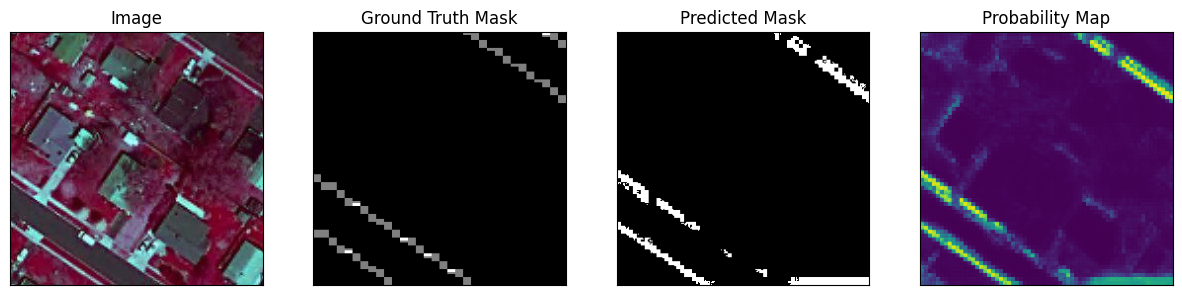

In [19]:
import random

# let's take a random training example
idx = random.randint(0, len(new_image_list)-1)

# load image
test_image = new_image_list[idx]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(new_label_list[idx])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the test image
axes[0].imshow(np.array(test_image), cmap='viridis')
axes[0].set_title("Image")

# Plot the ground truth mask
axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title("Ground Truth Mask")

# Plot the predicted mask
axes[2].imshow(medsam_seg, cmap='gray')
axes[2].set_title("Predicted Mask")

# Plot the probability map
axes[3].imshow(medsam_seg_prob)
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

**After testing a random point the following code will be evaluating the model using the entire validation dataset. The Dice coefficient is calculated for each predicted mask and the average of the dice coefficient value is calculated over the entire set.**

In [21]:
from tqdm import tqdm

def dice_coefficient(prediction, target):
    intersection = np.sum(prediction * target)
    union = np.sum(prediction) + np.sum(target)
    if union == 0:
        return 1.0
    return 2.0 * intersection / union

dice_scores = []

# Iterate over each image in the validation set and calculate dice coefficient
for i in range(len(new_image_list)):
    test_image = new_image_list[i]
    ground_truth_mask = np.array(new_label_list[i])
    prompt = get_bounding_box(ground_truth_mask)

    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()

    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    dice_score = dice_coefficient(medsam_seg, ground_truth_mask)
    dice_scores.append(dice_score)


average_dice = np.mean(dice_scores)
print("Average Dice coefficient:", average_dice)

Average Dice coefficient: 0.7334173546605657


After evaluating the validation dataset we get an average dice coefficient value of 0.73. This can be improved by running further epochs while finetuning the model.